# Exploratory Data Analysis

In this exercise, we are using machine learning as a tool for data exploration. We are interested in discovering the impact of the other attributes on PM10 dust concentration. One way to investigate this is to check the contribution of each attribute to the prediction accuracy of a learning algorithm. Our algorithm of chocie is [random forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) due to the interpretability of the resultant predictor. 

In [1]:
# Importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

ModuleNotFoundError: No module named 'pandas'

# Key packages
| package | Use |
| --- | --- |
| [minisom package](https://github.com/JustGlowing/minisom/blob/master/Readme.md) | Self-organizing maps (SOM) |
| [scikit-learn packages](https://scikit-learn.org/stable/index.html) | Machine learning |
| [matplotlib](https://matplotlib.org/3.1.1/index.html) | for plotting |

### Global figure settings
This piece of code sets the font size, line widths, figure title size, and resolution for all figures generated in this cookbook.

In [3]:
# customize figure 
import matplotlib as mpl
mpl.rcParams['font.size'] = 28
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.linewidth'] = 2.5
mpl.rcParams["axes.unicode_minus"] = True
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.bbox']='tight'
mpl.rcParams['hatch.linewidth'] = 2.5

# Import data

In [8]:
# Loading and visualizing the data
dust_df = pd.read_csv('../saharan_dust_met_vars.csv', index_col='time')
# print out shape of data 
print('Shape of data:', np.shape(dust_df))

# print first 5 rows of data
print(dust_df.head())

Shape of data: (18466, 10)
                 PM10         T2        rh2         slp       PBLH  RAINC  \
time                                                                        
1960-01-01  2000.1490  288.24875  32.923786  1018.89420  484.91812    0.0   
1960-01-02  4686.5370  288.88450  30.528862  1017.26575  601.58310    0.0   
1960-01-03  5847.7515  290.97128  26.504536  1015.83514  582.38540    0.0   
1960-01-04  5252.0586  292.20060  30.678936  1013.92230  555.11860    0.0   
1960-01-05  3379.3190  293.06076  27.790462  1011.94934  394.95440    0.0   

            wind_speed_10m  wind_speed_925hPa       U10       V10  
time                                                               
1960-01-01        6.801503          13.483623 -4.671345 -4.943579  
1960-01-02        8.316340          18.027075 -6.334070 -5.388977  
1960-01-03        9.148216          17.995173 -6.701636 -6.227193  
1960-01-04        8.751743          15.806478 -6.387379 -5.982842  
1960-01-05        6.39322

## What is the data distribution?
Understand your data first before usage. 

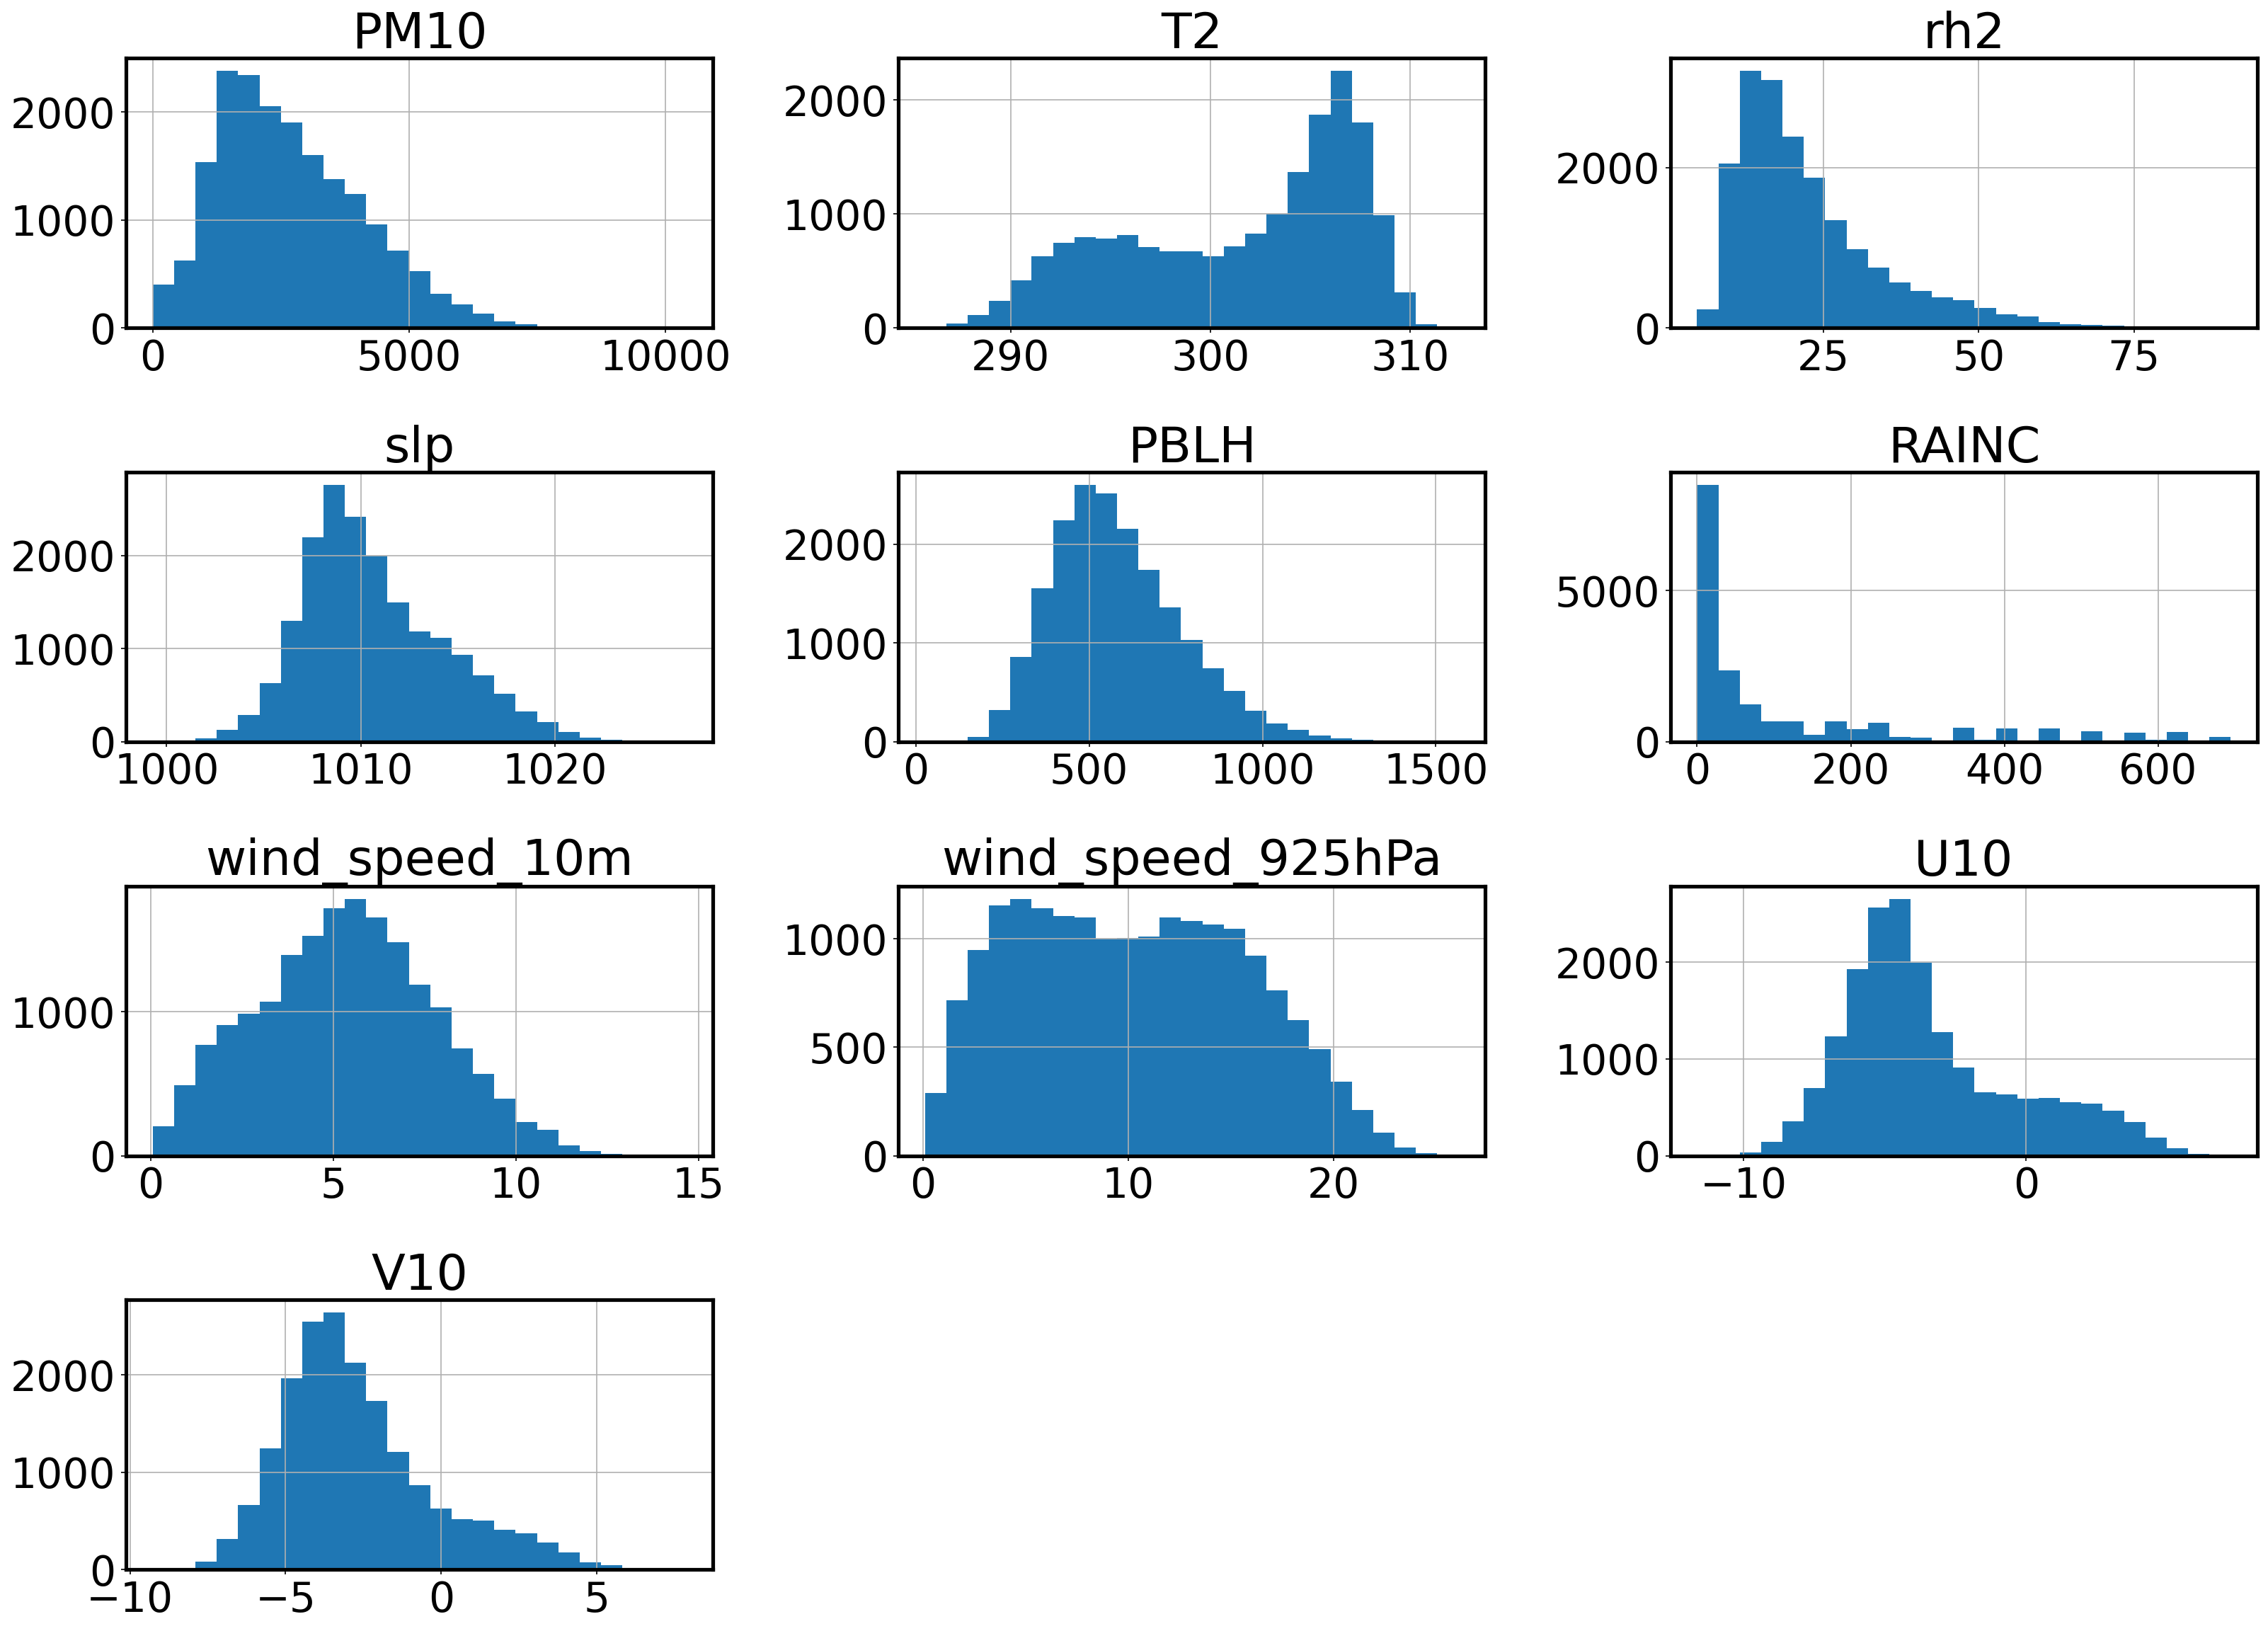

In [7]:
plt.rcParams['figure.figsize'] = [22, 16]
dust_df.hist(bins=25);
plt.tight_layout()

The histograms above are showing us the how the attributes vary across the samples in the dataset. The histogram that stands out the most is `RAINC` due to its strong concentration around a small section of its range. The long tail of the histogram extends to 700 to capture some rare occurences of heavy rain, but most days show little to no precipitation, falling under 100. In order to capture these rare events, the majority of the samples are compressed in a small range. To represent the typical days more accurately, we quantize `RAINC` to capture the rain events without the skewing effect of the concentrated distribution.

Using [AMS definitions](https://glossarytest.ametsoc.net/wiki/Rain), and keeping in mind that our data captures a 24 hour range, we use the following conversion on the `RAINC` attribute:
* 0        --> No rain (value `0`)
* (0, 24]  --> Drizzle (value `1`)
* (24,60]  --> Light rain (value `2`)
* (60,182] --> Moderate rain (value `3`)
* 182+     --> Heavy rain (value `4`)

In [15]:
# Converting the RAINC attribute
def cat_precip(row):
        if(row['RAINC'] == 0):
            return 0 #'NR'
        elif((row['RAINC'] > 0) and (row['RAINC'] <= 24)):
            return 1 #'D'
        elif((row['RAINC'] > 24) and (row['RAINC'] <= 60)):
            return 2 #'LR'
        elif((row['RAINC'] > 60) and (row['RAINC'] <= 182)):
            return 3 #'MR'
        elif(row['RAINC'] > 82):
            return 4 #'HR'

dust_df['RAIN'] = dust_df.apply(cat_precip, axis=1)
dust_df = dust_df.drop(columns=["RAINC"])

Another factor in feature engineering is the over-representation of the wind speed. In adition to the wind speed attributes at two elevations (`wind_speed_10m`, `wind_speed_925hPa`), we have the `U10` and `V10` variables implicitly encoding the same information. We reduce this over-emphasis by converting the latter two variables into a categorical attribute that only encodes the wind direction in one of the 4 possible values: Southeast (`SE`), Southwest (`SW`), Northeast (`NE`) and Northwest (`NW`). In our dataset there is no instance where either of the directions are zero, so we don't need to represent the directions East, West, South and North.

For further applications that qould require further detail in wind direction, one might consider increasing the granularity by including more categories like North-Northwest, West-Northwest, etc. that captures which of the two primary directions the wind is closer to.

In [16]:
# Converting U10 and V10 attributes
def cat_wind_dir(row):
    if((row['U10']>=0) and (row['V10']>=0)):
        return 'SW'
    if((row['U10']>=0) and (row['V10']<0)):
        return 'NW'
    if((row['U10']<0) and (row['V10']>=0)):
        return 'SE'
    else:
        return 'NE'

dust_df['WIND_DIR'] = dust_df.apply(cat_wind_dir, axis=1)
dust_df = dust_df.drop(columns=['U10','V10'])
dust_df.head()

,PM10,T2,rh2,slp,PBLH,wind_speed_10m,wind_speed_925hPa,RAIN,WIND_DIR
time,,,,,,,,,
1960-01-01,2000.1490,288.24875,32.923786,1018.89420,484.91812,6.801503,13.483623,0,NE
1960-01-02,4686.5370,288.88450,30.528862,1017.26575,601.58310,8.316340,18.027075,0,NE
1960-01-03,5847.7515,290.97128,26.504536,1015.83514,582.38540,9.148216,17.995173,0,NE
1960-01-04,5252.0586,292.20060,30.678936,1013.92230,555.11860,8.751743,15.806478,0,NE
1960-01-05,3379.3190,293.06076,27.790462,1011.94934,394.95440,6.393228,9.160809,0,NE


## NB: This dataframe of dust_df is saved on disk for future use.

## Are there any outliers?
Some machine learning models do not perform well when there are outliers in the data. This section explores the data for any potential outliers. The boxplots show there are outliers in the data, hence we need to use a scaling method which is robust on outliers.

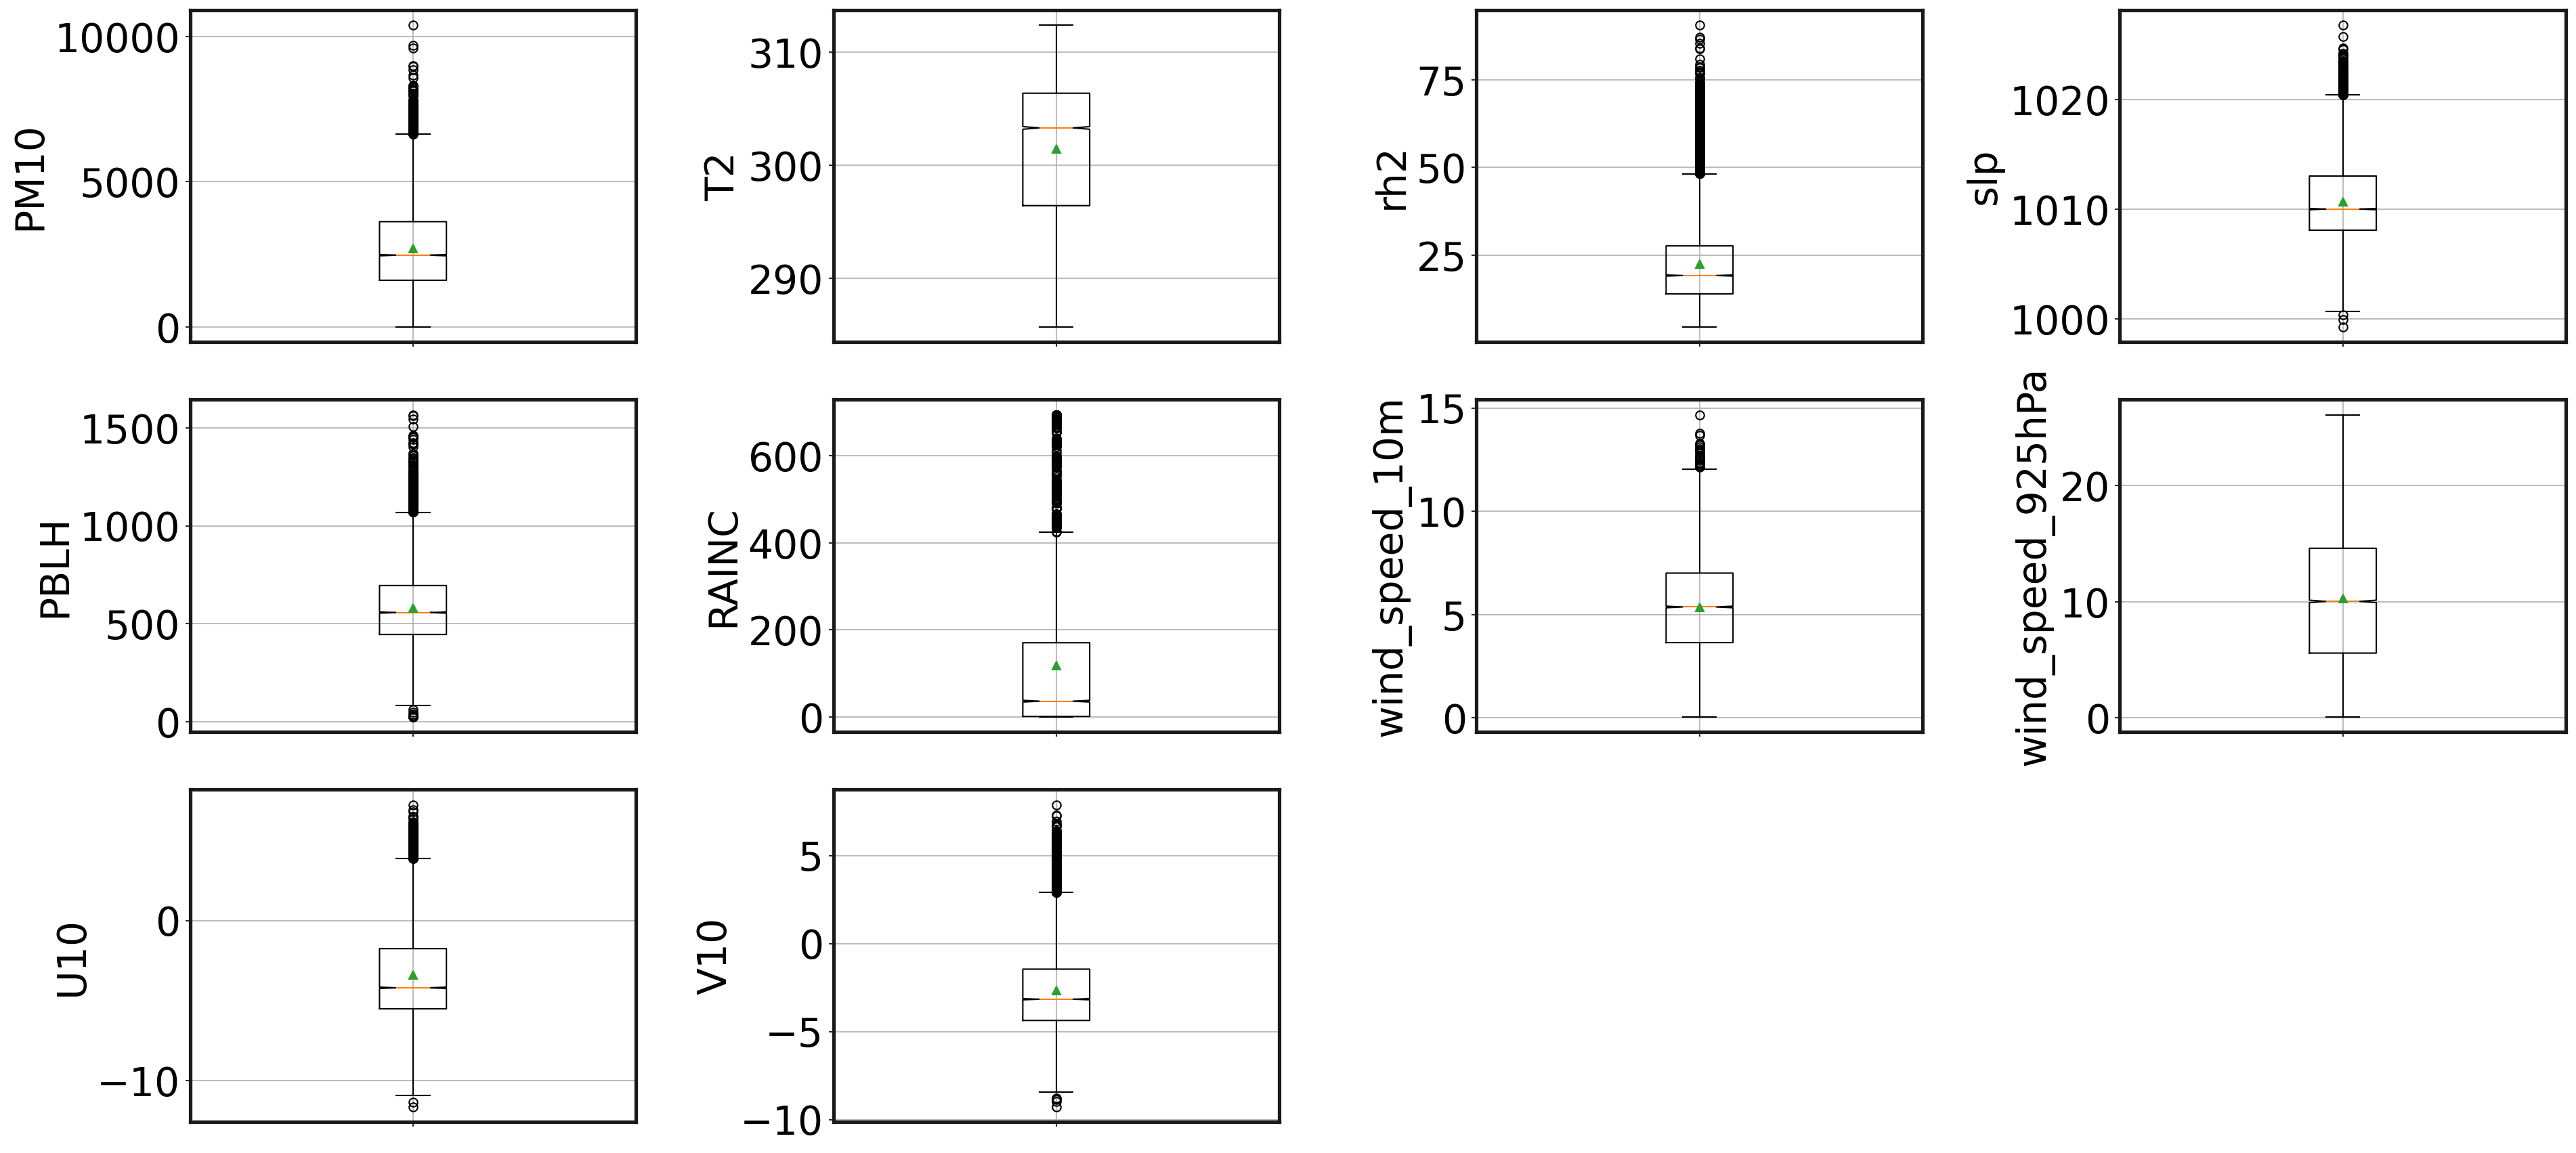

In [13]:
dust_df = pd.read_csv('../saharan_dust_met_vars.csv', index_col='time')
feature_names = dust_df.columns

fig, ax = plt.subplots(3,4, figsize=(26,12))
ax = ax.flatten()
for ind, col in enumerate(feature_names):
    ax[ind].boxplot(dust_df[col].dropna(axis=0), 
                    notch=True, whis=1.5,  
                    showmeans=True)
    ax[ind].grid(which='minor', axis='both')
    ax[ind].set_xticklabels([''])
    ax[ind].set_ylabel(col)
    #ax[ind].set_title(col)
    ax[ind].set_facecolor('white')
    ax[ind].spines['bottom'].set_color('0.1')
    ax[ind].spines['top'].set_color('0.1')
    ax[ind].spines['right'].set_color('0.1')
    ax[ind].spines['left'].set_color('0.1')
    ax[ind].grid(True)
    ax[10].set_axis_off()
    ax[11].set_axis_off()
fig.tight_layout()
#plt.savefig('box_plots.png')

## Scaling the variables

As you can see, there is a large range of values among variables. SOM and PCA are scale variant, so to not influence the results as it is the case in many unsupervised machine learning models, it is important to scale them. Many scaling methods exist, but we will use the robust scaling method since this takes care of outliers.

This concludes the primary exploration of our data. We now do a deeper dive into our exploration by using statistical analysis through Principal Component Analysis.